# CS 20 : TensorFlow for Deep Learning Research
## Lecture 07 : ConvNet in TensorFlow
same contents, but different style with [Lec07_ConvNet mnist by high-level.ipynb](https://nbviewer.jupyter.org/github/aisolab/CS20/blob/master/Lec07_ConvNet%20in%20Tensorflow/Lec07_ConvNet%20mnist%20by%20high-level.ipynb)

### ConvNet mnist by high-level
- Creating the **data pipeline** with `tf.data`
- Using `tf.keras`, alias `keras` and `eager execution`
- Creating the model as **Class** by subclassing `tf.keras.Model`
- Training the model with **Drop out** technique by `tf.keras.layers.Dropout`
- Using tensorboard

### Setup

In [1]:
from __future__ import absolute_import, division, print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

print(tf.__version__)
tf.enable_eager_execution()

1.12.0


### Load and Pre-process data

In [2]:
(x_train, y_train), (x_tst, y_tst) = tf.keras.datasets.mnist.load_data()
x_train = x_train  / 255
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)
x_tst = x_tst / 255
x_tst = x_tst.reshape(-1, 28, 28, 1).astype(np.float32)

In [3]:
tr_indices = np.random.choice(range(x_train.shape[0]), size = 55000, replace = False)

x_tr = x_train[tr_indices]
y_tr = y_train[tr_indices].astype(np.int32)

x_val = np.delete(arr = x_train, obj = tr_indices, axis = 0)
y_val = np.delete(arr = y_train, obj = tr_indices, axis = 0).astype(np.int32)

print(x_tr.shape, y_tr.shape)
print(x_val.shape, y_val.shape)

(55000, 28, 28, 1) (55000,)
(5000, 28, 28, 1) (5000,)


### Define SimpleCNN class by high-level api

In [4]:
class SimpleCNN(keras.Model):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.__conv1 = keras.layers.Conv2D(filters=32, kernel_size=[5,5], padding='same',
                                           kernel_initializer=keras.initializers.truncated_normal(),
                                           bias_initializer=keras.initializers.truncated_normal(),
                                           activation=tf.nn.relu)
        self.__conv2 = keras.layers.Conv2D(filters=64, kernel_size=[5,5], padding='same',
                                           kernel_initializer=keras.initializers.truncated_normal(),
                                           bias_initializer=keras.initializers.truncated_normal(),
                                           activation=tf.nn.relu)
        self.__pool = keras.layers.MaxPooling2D()
        self.__flatten = keras.layers.Flatten()
        self.__dropout = keras.layers.Dropout(rate =.5)
        self.__dense1 = keras.layers.Dense(units=1024, activation=tf.nn.relu, 
                                           kernel_initializer=keras.initializers.truncated_normal(),
                                           bias_initializer=keras.initializers.truncated_normal())
        self.__dense2 = keras.layers.Dense(units=num_classes,
                                           kernel_initializer=keras.initializers.truncated_normal(),
                                           bias_initializer=keras.initializers.truncated_normal())
    
    def call(self, inputs, training=False):
        conv1 = self.__conv1(inputs)
        pool1 = self.__pool(conv1)
        conv2 = self.__conv2(pool1)
        pool2 = self.__pool(conv2)
        flattened = self.__flatten(pool2)
        fc = self.__dense1(flattened)
        if training:
            fc = self.__dropout(fc, training=training)
        score = self.__dense2(fc)
        return score

### Preparing for training a model

In [5]:
# hyper-parameter
lr = .001
epochs = 10
batch_size = 100
total_step = int(x_tr.shape[0] / batch_size)
print(total_step)

550


In [6]:
## create input pipeline with tf.data
# for train
tr_dataset = tf.data.Dataset.from_tensor_slices((x_tr, y_tr))
tr_dataset = tr_dataset.shuffle(buffer_size = 10000)
tr_dataset = tr_dataset.batch(batch_size = batch_size)
print(tr_dataset)

# for validation
val_dataset = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_dataset = val_dataset.batch(batch_size = batch_size)
print(val_dataset)

## create optimizer
opt = tf.train.AdamOptimizer(learning_rate = lr)

<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>


In [7]:
def loss_fn(model, x, y, training):
    score = model(x, training)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=score)

### Training a model

In [8]:
cnn = SimpleCNN(num_classes=10)

In [9]:
# creating check point (Object-based saving)
checkpoint_dir = '../graphs/lecture07/convnet_mnist_high_kde/'
checkpoint_prefix = os.path.join(checkpoint_dir, 'cnn')
checkpoint = tf.train.Checkpoint(cnn=cnn)

# create writer for tensorboard
summary_writer = tf.contrib.summary.create_file_writer(logdir=checkpoint_dir)

In [10]:
tr_loss_hist = []
val_loss_hist = []

for epoch in range(epochs):

    avg_tr_loss = 0
    avg_val_loss = 0
    tr_step = 0
    val_step = 0


    with summary_writer.as_default(), tf.contrib.summary.always_record_summaries(): # for tensorboard
        # for training
        for x_mb, y_mb in tr_dataset:
            with tf.GradientTape() as tape:
                tr_loss = loss_fn(cnn, x_mb, y_mb, training = True)     
                grads = tape.gradient(target=tr_loss, sources=cnn.variables)
            opt.apply_gradients(grads_and_vars=zip(grads, cnn.variables))
            tf.contrib.summary.scalar(name='tr_loss', tensor=tr_loss)
            avg_tr_loss += tr_loss
            tr_step += 1
        else:
            avg_tr_loss /= tr_step
            tr_loss_hist.append(avg_tr_loss)
            
        # for validation
        for x_mb, y_mb in val_dataset:
            val_loss = loss_fn(cnn, x_mb, y_mb, training = False)
            tf.contrib.summary.scalar(name='val_loss', tensor=val_loss)
            avg_val_loss += val_loss
            val_step += 1
        else:
            avg_val_loss /= val_step
            val_loss_hist.append(avg_val_loss)
    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch + 1, avg_tr_loss, avg_val_loss))

checkpoint.save(file_prefix=checkpoint_prefix)

epoch :   1, tr_loss : 0.159, val_loss : 0.052
epoch :   2, tr_loss : 0.048, val_loss : 0.031
epoch :   3, tr_loss : 0.034, val_loss : 0.028
epoch :   4, tr_loss : 0.025, val_loss : 0.025
epoch :   5, tr_loss : 0.021, val_loss : 0.031
epoch :   6, tr_loss : 0.015, val_loss : 0.025
epoch :   7, tr_loss : 0.014, val_loss : 0.033
epoch :   8, tr_loss : 0.013, val_loss : 0.024
epoch :   9, tr_loss : 0.011, val_loss : 0.034
epoch :  10, tr_loss : 0.008, val_loss : 0.026


'../graphs/lecture07/convnet_mnist_high_kde/cnn-1'

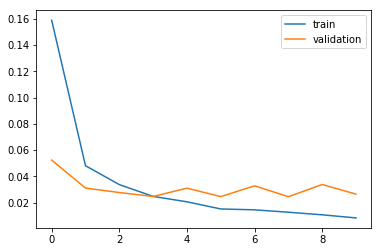

In [11]:
plt.plot(tr_loss_hist, label = 'train')
plt.plot(val_loss_hist, label = 'validation')
plt.legend()

In [12]:
yhat = np.argmax(cnn.predict(x_tst), axis=-1)
print('test acc: {:.2%}'.format(np.mean(yhat == y_tst)))

test acc: 99.34%
